### Characterization of Enamel structure by 4D-STEM

- This is a series of scripts to analyze 4DSTEM data of Enamel samples acquired using K3-IS synchronized with STEMx
- Microscope: JEOL ARM300F operated at 300kV


In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

**DataSet #1**

- Experimental scan dimensions: [133,131,256,256]

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel (perpendicular).dm4'
datacube = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel (perpendicular).dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
datacube.data.shape

(132, 300, 256, 256)

In [3]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(132,300)
datacube.name = 'datacube'

**Generate virtual images**

1. Create virtual masks using average diffraction

<IPython.core.display.Javascript object>


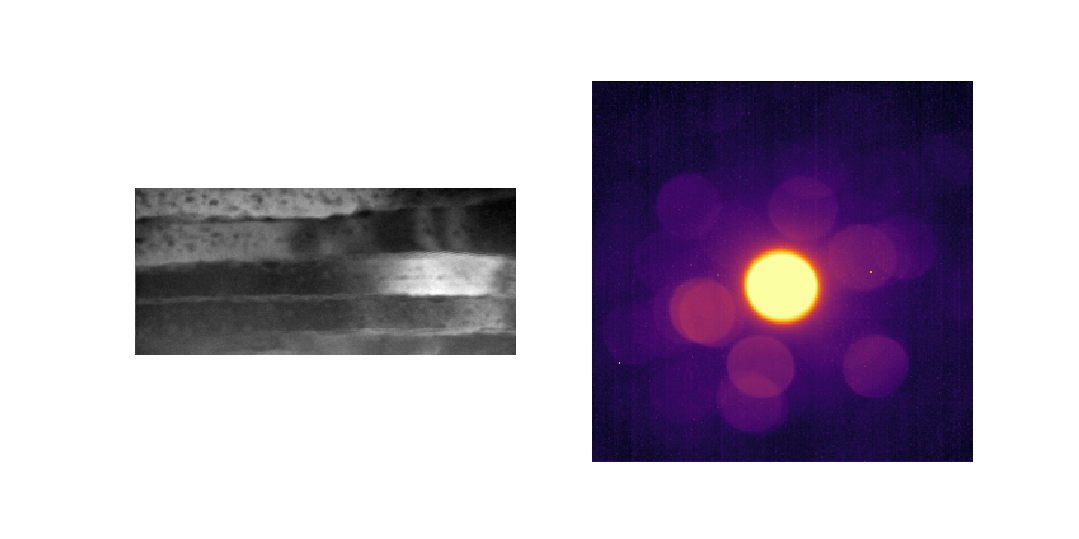

In [24]:
#take average diffraction pattern accross whole area
aveDP = np.average(datacube.data, axis=(0,1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,3))

#plot real space image
ax1.matshow(np.average(datacube.data, axis=(2,3)))

#plot sqrt of average diffraciton pattern 
ax2.matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [44]:
realimage=np.average(datacube.data, axis=(2,3))

xreal=np.arange(15, 287, 34)
yreal=35*np.ones(8)

radius=8

output=[]
#integrae from summed vectors

output.append(realimage)

for k in range(len(xreal)): 
    x, y = np.indices((realimage.shape[0], realimage.shape[1]))
    mask_circle1 = (yreal[k]-x) ** 2 + (xreal[k]-y) ** 2 < radius ** 2
    
    DP=np.zeros((datacube.data.shape[2],datacube.data.shape[3]))

    for i in range(0,realimage.shape[0]):
        for j in range(0,realimage.shape[1]): 
            if mask_circle1[i,j]: 
                DP=DP+datacube.data[i,j,:,:] 
    output.append(DP)

<IPython.core.display.Javascript object>


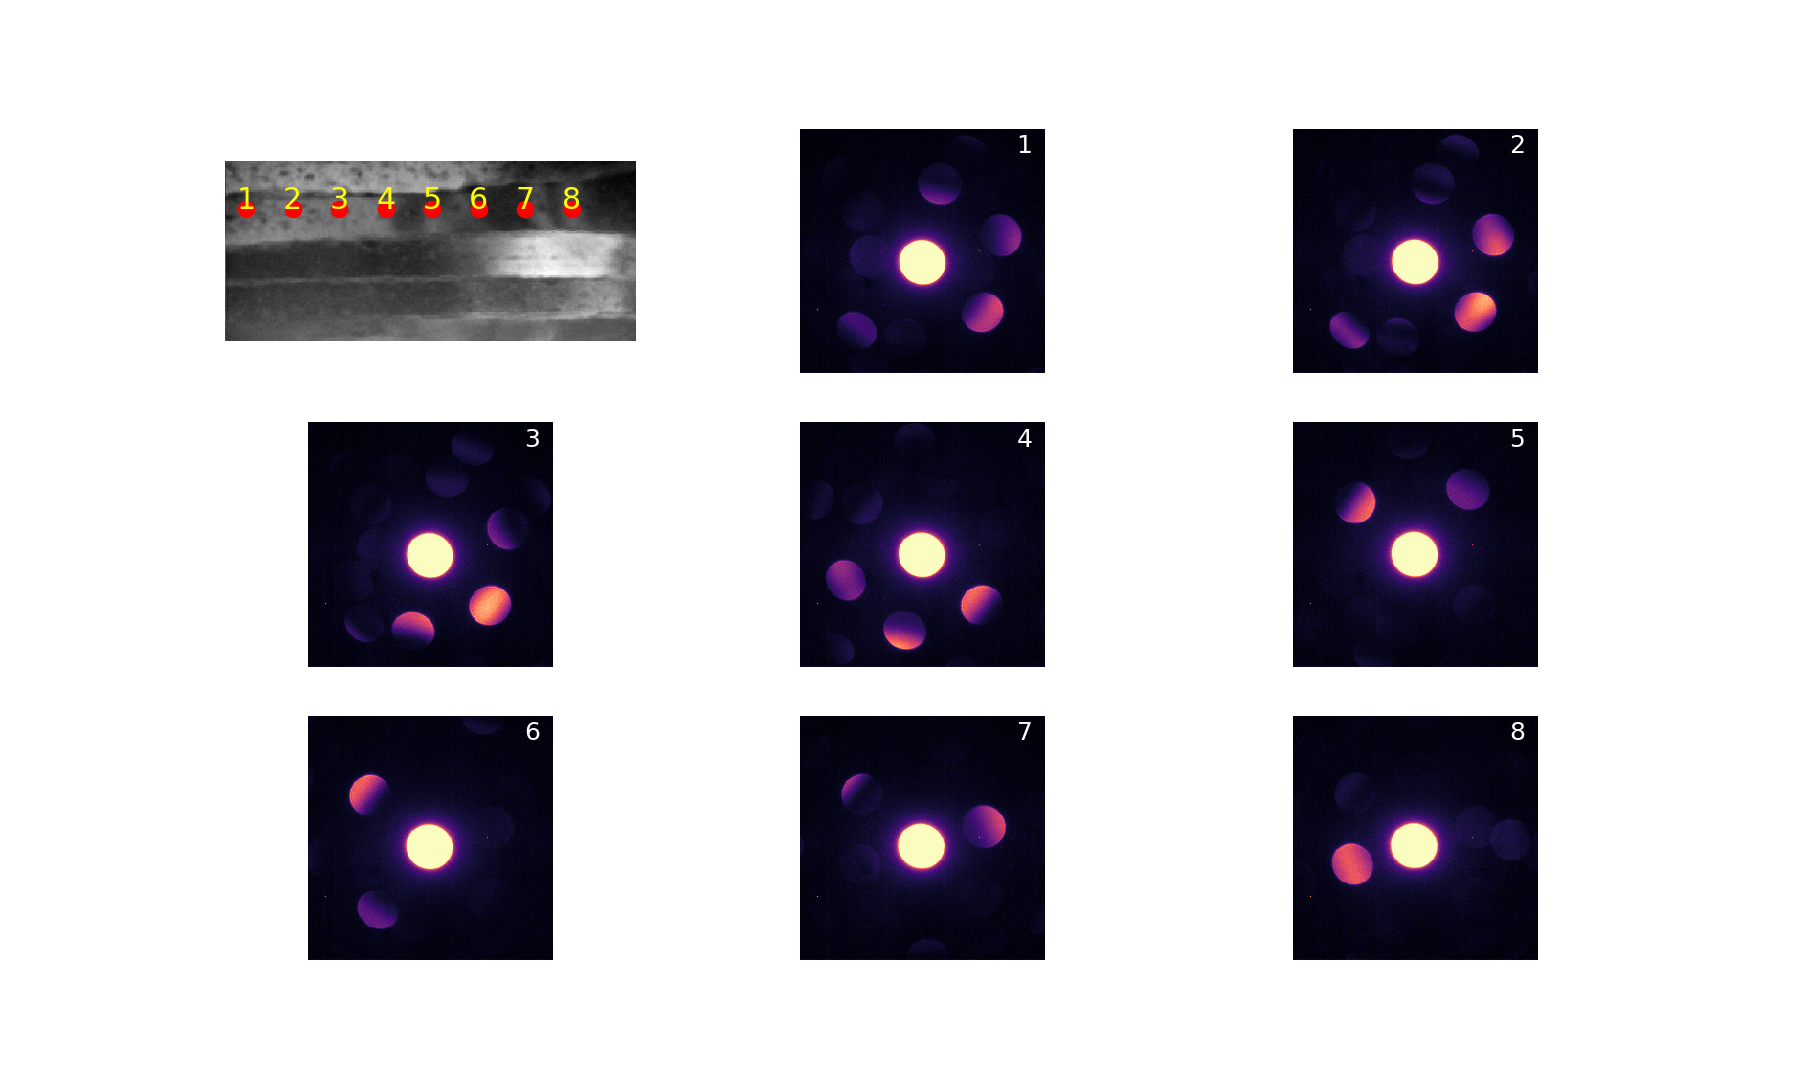

In [45]:
titles=[None,1,2,3,4,5,6,7,8,9,10,11]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,6))
for ax, feature, name in zip(axes.flatten(), output, titles):
    ax.imshow(feature, cmap=plt.cm.magma)
    #ax.set(title=name, x=0.9, y=0.9)
    ax.text(0.95, 0.9, name, transform=ax.transAxes, ha="right", color='white')
    ax.axis('off')
axes[0,0].matshow(np.sqrt(realimage), cmap = plt.cm.gray) 

for xx, yy, labels in zip(xreal, yreal, range(1,12)): 
#    print(xx,yy,text)
    axes[0,0].text(xx,yy,str(labels),ha='center', size=12, color="yellow")   
    axes[0,0].scatter(xx,yy, color="red")
plt.show()

In [6]:
#find center of diffraction pattern

from skimage import feature
blob=feature.blob_log(aveDP, threshold = 100)
ic=blob[0,0]
jc=blob[0,1]
print("ic is " + str(ic))
print("jc is " + str(jc))
#expected about (125,138) for (x,y), somehow powder center switched x and y so keep that in mind for the future  

ic is 137.5
jc is 127.0


In [7]:
#Prepare BF, ADF masks

# Make a bright field image by centering a circular virtual detector about the unscattered beam
from matplotlib.patches import Rectangle, Circle

detector_radius = 20
qx,qy = ic,jc         # Select center of virtual detector

qx0,qxf = int(qx-detector_radius),int(qx+detector_radius)
qy0,qyf = int(qy-detector_radius),int(qy+detector_radius)



BF = datacube.get_virtual_image_circ_integrate(slice(qx0,qxf),slice(qy0,qyf))[0]
# ABF =
# ADF =


<IPython.core.display.Javascript object>


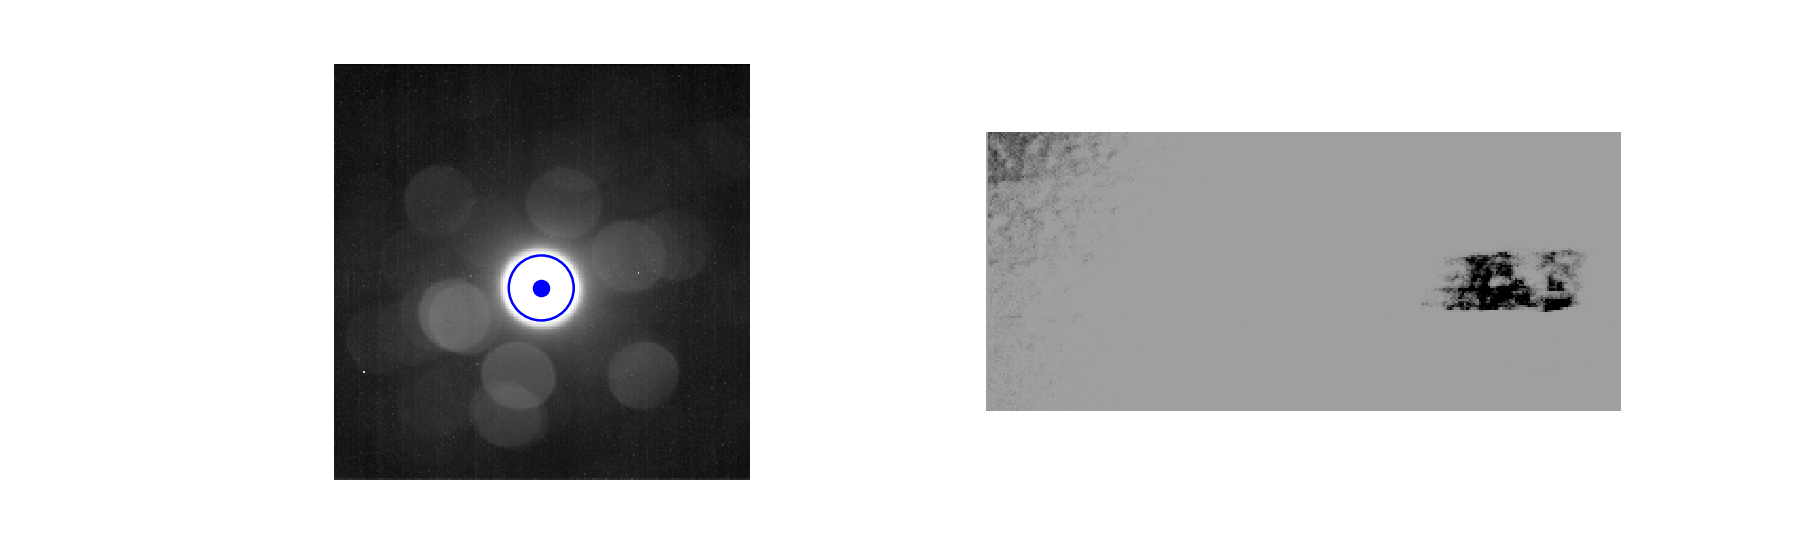

In [8]:
# Show
fig,axs = plt.subplots(1,2,figsize=(10,3))

axs[0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
#axs[1].matshow(BF)
axs[1].matshow(np.sqrt(BF), vmin=564, vmax=570)

circ = Circle((qy,qx),detector_radius,fill=False,color='b')
axs[0].scatter(qy,qx,color='b')
axs[0].add_patch(circ)


axs[0].axis('off')
axs[1].axis('off')

plt.show()

<IPython.core.display.Javascript object>


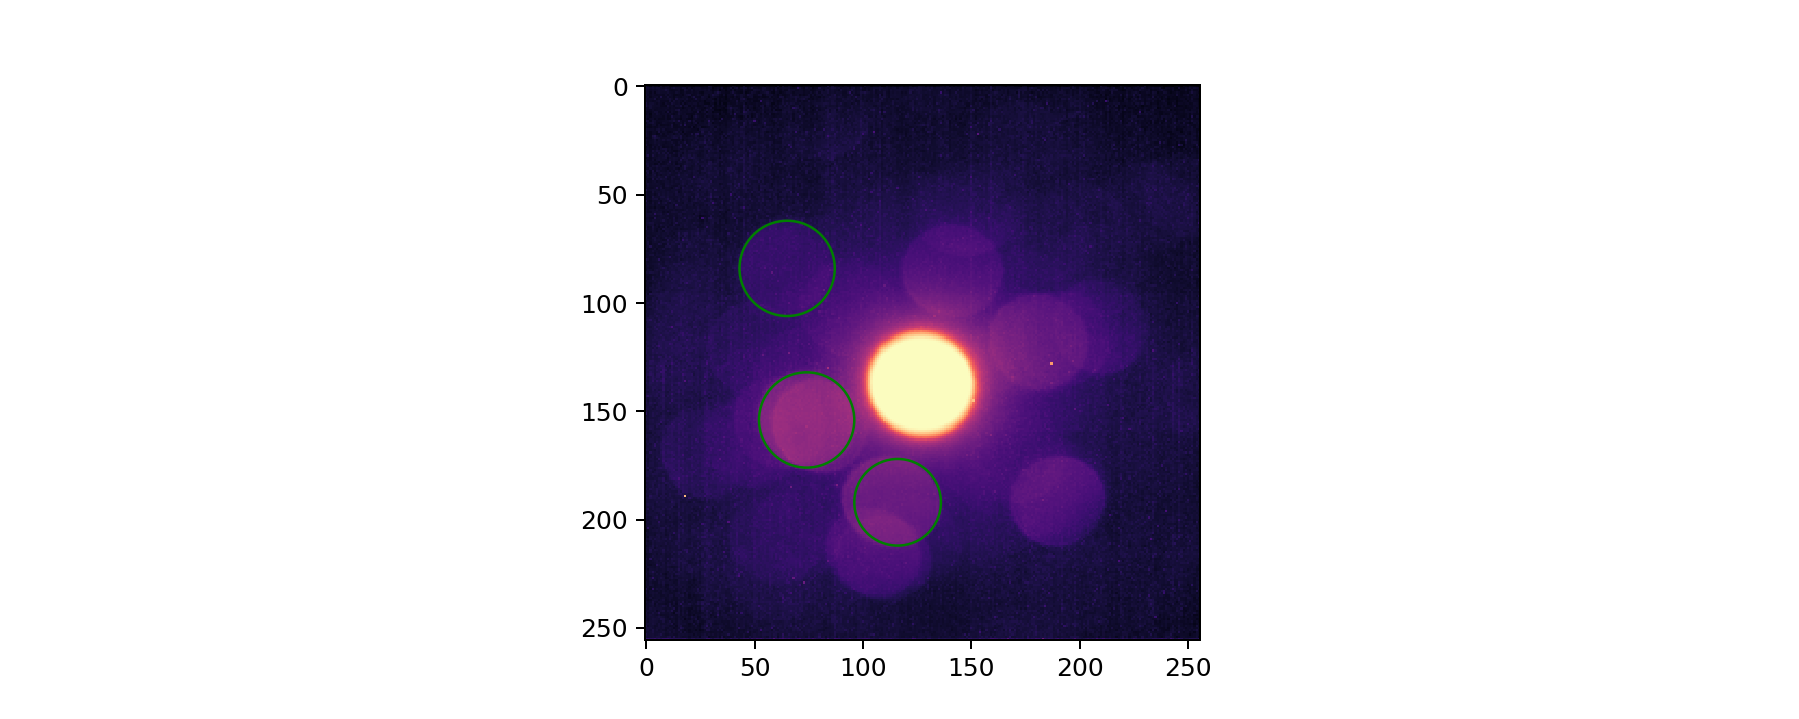

In [9]:
#let's start again using slightly different parameters for the hough transform 

#write over aveDP since we edited it for the last hough transfrom
aveDP =np.average(datacube.data, axis=(0,1))
aveDP=np.sqrt(aveDP)


from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter

# Load picture and detect edges


image = aveDP
#edges = canny(image, sigma=0.5, high_threshold=5, low_threshold=3.4)
edges = canny(image, sigma=0.3)

# Detect two radii
hough_radii = np.arange(18, 25, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3, min_xdistance=20, min_ydistance=20)

# Draw them
fig, ax = plt.subplots(figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    circ = Circle((center_x,center_y),radius,fill=False,color='g')
    ax.add_patch(circ)
ax.imshow(image, cmap=plt.cm.magma)
plt.show()

In [10]:
#remove circles that are on top of eachother
p = cx.argsort()
cx=cx[p]
cy=cy[p]

#min distance can be changed
MIN_DISTANCE = 4

for i in range(len(cx)-1):
    if(cx[i+1] - cx[i] < MIN_DISTANCE):
        cx[i+1] = cx[i]
        cy[i+1] = cy[i]

        
        
_, idx = np.unique(cx, return_index=True)
cx=cx[np.sort(idx)]

_, idx = np.unique(cy, return_index=True)
cy=cy[np.sort(idx)]

#cx = np.unique(cx)
#cy = np.unique(cy)

<IPython.core.display.Javascript object>


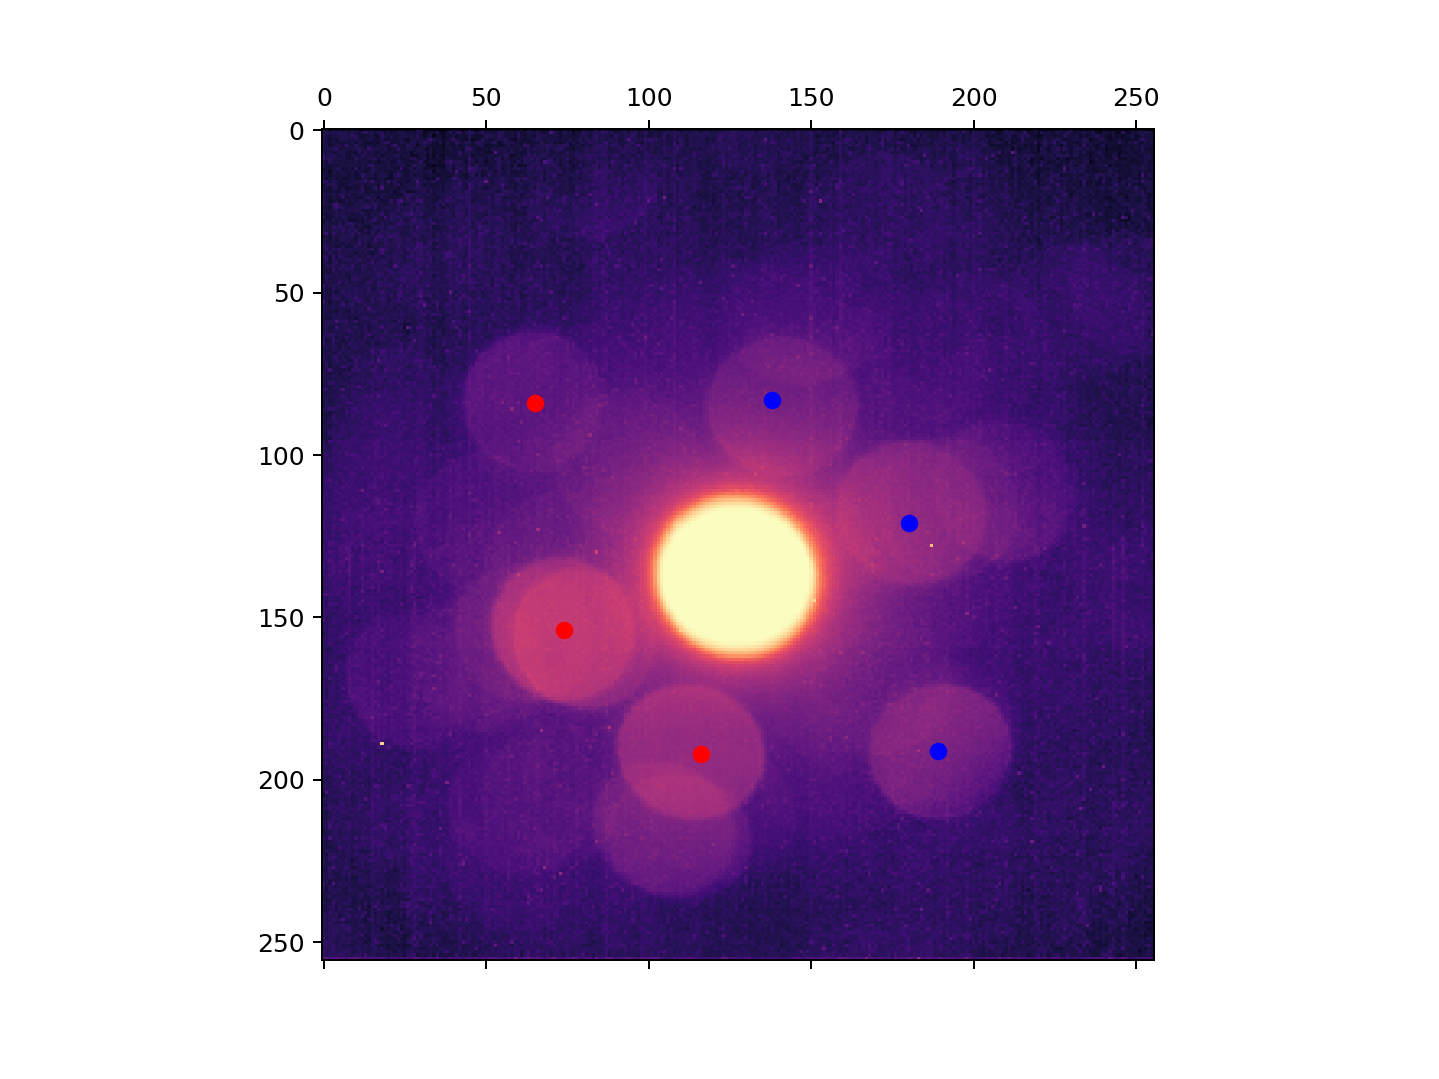

In [11]:
cx_2=-cx+jc*2
cy_2=-cy+ic*2

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
plt.show()

[ 65  74 116]
[ 65  74 116]


/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  after removing the cwd from sys.path.
/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """
/Users/sribet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


<IPython.core.display.Javascript object>


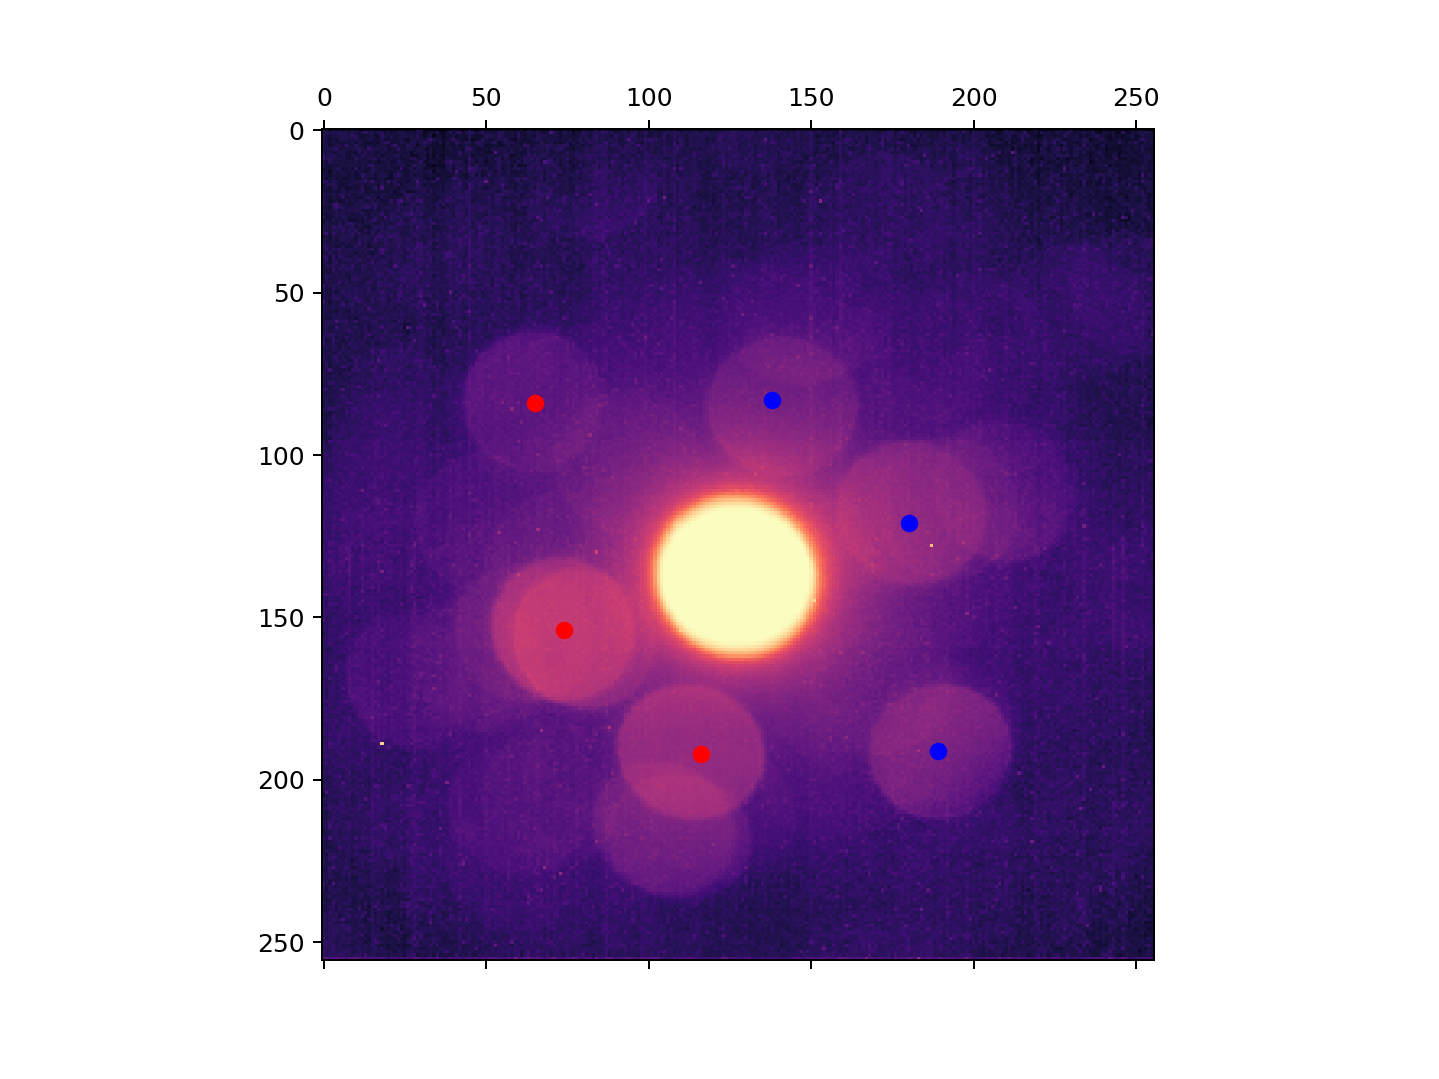

In [12]:
#let's remove the circles that are diametrically opposed 
print(cx)
cx=np.delete(cx,[4])
cy=np.delete(cy,[4])
cx_2=np.delete(cx_2,[4])
cy_2=np.delete(cy_2,[4])
print(cx)

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
plt.show()

In [13]:
#let's extract all data simultaneously 
output=[]
masks=[]
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(0, len(cx)):
    mask_circle1 = (x - cy[k]) ** 2 + (y - cx[k]) ** 2 < 20 ** 2
    mask_circle2 = (x - cy_2[k]) ** 2 + (y - cx_2[k]) ** 2 < 20 ** 2
    combine_mask = np.logical_or(mask_circle1, mask_circle2)
    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

<IPython.core.display.Javascript object>


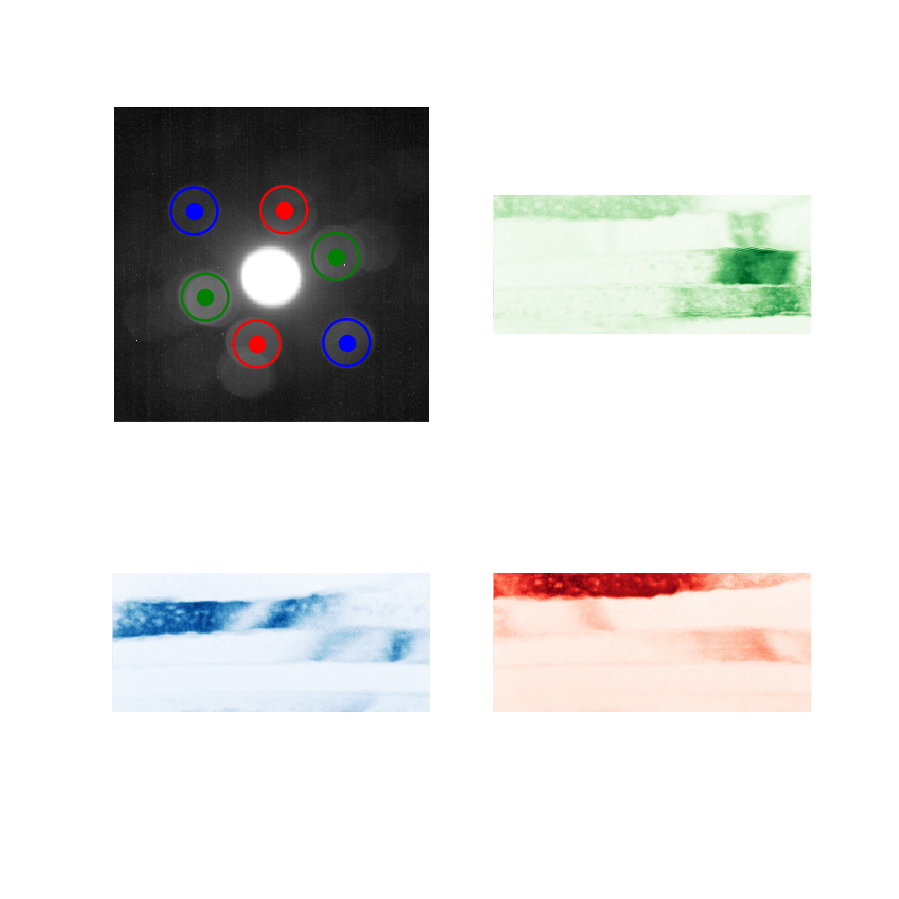

In [14]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(5,5))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((cx[0],cy[0]),19,fill=False,color='b')
axs[0,0].scatter(cx[0],cy[0],color='b')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[0],cy_2[0]),19,fill=False,color='b')
axs[0,0].scatter(cx_2[0],cy_2[0],color='b')
axs[0,0].add_patch(circ1)
#axs[0,0].matshow(masks[2]) #for checking mask alignment 

circ1 = Circle((cx[1],cy[1]),19,fill=False,color='g')
axs[0,0].scatter(cx[1],cy[1],color='g')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[1],cy_2[1]),19,fill=False,color='g')
axs[0,0].scatter(cx_2[1],cy_2[1],color='g')
axs[0,0].add_patch(circ1)

circ1 = Circle((cx[2],cy[2]),19,fill=False,color='r')
axs[0,0].scatter(cx[2],cy[2],color='r')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[2],cy_2[2]),19,fill=False,color='r')
axs[0,0].scatter(cx_2[2],cy_2[2],color='r')
axs[0,0].add_patch(circ1)


#circ1 = Circle((cx[3],cy[3]),19,fill=False,color='purple')
#axs[0,0].scatter(cx[3],cy[3],color='purple')
#axs[0,0].add_patch(circ1)
#circ1 = Circle((cx_2[3],cy_2[3]),19,fill=False,color='purple')
#axs[0,0].scatter(cx_2[3],cy_2[3],color='purple')
#axs[0,0].add_patch(circ1)


#circ1 = Circle((cx[4],cy[4]),19,fill=False,color='orange')
#axs[0,0].scatter(cx[4],cy[4],color='orange')
#axs[0,0].add_patch(circ1)
#circ1 = Circle((cx_2[4],cy_2[4]),19,fill=False,color='orange')
#axs[0,0].scatter(cx_2[4],cy_2[4],color='orange')
#axs[0,0].add_patch(circ1)

#circ1 = Circle((cx[5],cy[5]),19,fill=False,color='yellow')
#axs[0,0].scatter(cx[5],cy[5],color='yellow')
#axs[0,0].add_patch(circ1)
#circ1 = Circle((cx_2[5],cy_2[5]),19,fill=False,color='yellow')
#axs[0,0].scatter(cx_2[5],cy_2[5],color='yellow')
#axs[0,0].add_patch(circ1)

axs[1,0].matshow(output[0], cmap = plt.cm.Blues)
axs[0,1].matshow(output[1], cmap = plt.cm.Greens)
axs[1,1].matshow(output[2], cmap = plt.cm.Reds)
#axs[0,2].matshow(output[3], cmap = plt.cm.Purples)
#xs[1,2].matshow(output[4], cmap = plt.cm.Oranges)
#axs[2,0].matshow(output[5], cmap = plt.cm.YlOrRd)


axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')
#axs[0,2].axis('off')
#axs[1,2].axis('off')
#axs[2,0].axis('off')


plt.show()

<IPython.core.display.Javascript object>


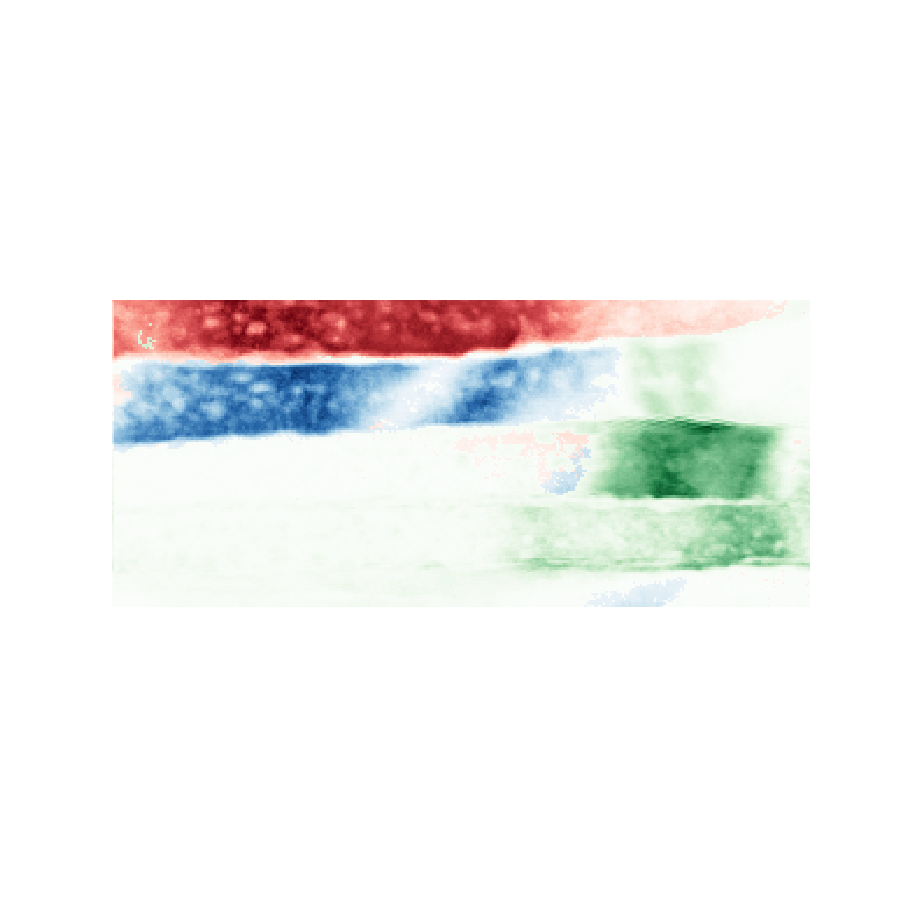

In [15]:
from matplotlib.colors import ListedColormap

new_output=output
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if new_output[0][i,j] >= new_output[1][i,j] and new_output[0][i,j] >= new_output[2][i,j]:
                new_output[1][i,j]=0
                new_output[2][i,j]=0
            if new_output[1][i,j] > new_output[0][i,j] and new_output[1][i,j] > new_output[2][i,j]:
                new_output[0][i,j]=0
                new_output[2][i,j]=0
            if new_output[2][i,j] > new_output[1][i,j] and new_output[2][i,j] > new_output[0][i,j]: 
                new_output[1][i,j]=0
                new_output[0][i,j]=0
                
#make your own color bars with transparent instead of white as lower bound                
cmap = plt.cm.Reds
my_red = cmap(np.arange(cmap.N))
my_red[:,-1] = np.linspace(0, 1, cmap.N)
my_red = ListedColormap(my_red)

cmap = plt.cm.Greens
my_green = cmap(np.arange(cmap.N))
my_green[:,-1] = np.linspace(0, 1, cmap.N)
my_green= ListedColormap(my_green)

cmap = plt.cm.Blues
my_blue = cmap(np.arange(cmap.N))
my_blue[:,-1] = np.linspace(0, 1, cmap.N)
my_blue = ListedColormap(my_blue)

cmap = plt.cm.Purples
my_purple = cmap(np.arange(cmap.N))
my_purple[:,-1] = np.linspace(0, 1, cmap.N)
my_purple = ListedColormap(my_purple)

cmap = plt.cm.Oranges
my_orange = cmap(np.arange(cmap.N))
my_orange[:,-1] = np.linspace(0, 1, cmap.N)
my_orange = ListedColormap(my_orange)


#@Paul, if you adjust the "vmax" values you will change the contrast of each color to make the grains glow
#Below is an example
#in general you can also add a "vmin" term but in this case, it will just lead to white space

fig,axs = plt.subplots(figsize=(5,5))
axs.matshow(new_output[0], cmap = my_blue)
axs.matshow(new_output[1], cmap = my_green)
axs.matshow(new_output[2], cmap = my_red)
#axs.matshow(new_output[3], cmap = my_purple, vmax=300000)
#axs.matshow(new_output[4], cmap = my_orange, vmax=200000)

axs.axis('off')
plt.show()

fig.savefig('grain.png')

In [16]:
#get real space image
realimage=np.average(datacube.data, axis=(2,3))

<IPython.core.display.Javascript object>


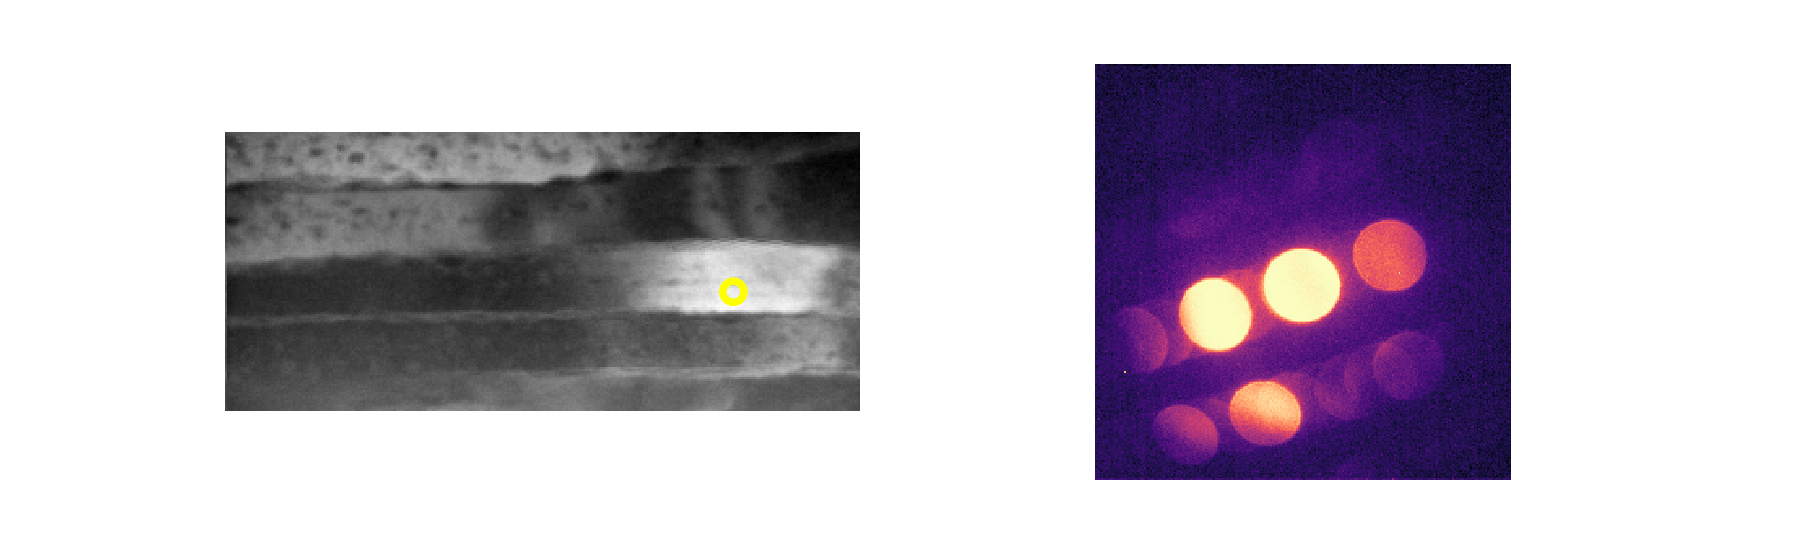

In [17]:
#integrate a specific grain area

#edit here only! x and y selected with cursor do not match x and y integration
xreal=240
yreal=75
radius=5

#integrae from summed vectors
x, y = np.indices((realimage.shape[0], realimage.shape[1]))
mask_circle1 = (yreal-x) ** 2 + (xreal-y) ** 2 < radius ** 2
    
DP=np.zeros((datacube.data.shape[2],datacube.data.shape[3]))

for i in range(0,realimage.shape[0]):
    for j in range(0,realimage.shape[1]): 
            if mask_circle1[i,j]: 
                DP=DP+datacube.data[i,j,:,:] 

                
fig,axs = plt.subplots(1,2,figsize=(10,3))

axs[0].matshow(np.sqrt(realimage), cmap = plt.cm.gray)
axs[1].matshow(np.sqrt(DP), cmap = plt.cm.magma)
#axs[0].matshow(mask_circle1)


circ = Circle((xreal,yreal),radius,fill=False,color='yellow',lw=3)
axs[0].add_patch(circ)

axs[0].axis('off')
axs[1].axis('off')

plt.show()


In [18]:
#let's manually pick the cx and cy we want
cx=np.array([65.5, 73.8, 85.0])
cy=np.array([85, 154.2, 160.0])

theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

six_mask_x=[]
six_mask_y=[]
for i in range(len(cx)):
    v=np.array([[cx[i]-jc],[cy[i]-ic]])
    six_x=np.zeros((1,6))
    six_y=np.zeros((1,6))
    six_x[0,0]=cx[i]
    six_y[0,0]=cy[i]
    for j in range(1,6):
        v=np.dot(v.T,R).T
        six_x[0,j]=v[0,0]+jc
        six_y[0,j]=v[1,0]+ic
    
    six_mask_x.append(six_x)
    six_mask_y.append(six_y)

six_mask_x=np.asarray(six_mask_x)
six_mask_y=np.asarray(six_mask_y)
six_mask_x=np.reshape(six_mask_x, (3,6))
six_mask_y=np.reshape(six_mask_y, (3,6))

In [19]:
output=[]
masks=[]
rad=22
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(3):
    mask_circle1 = (x - six_mask_y[k,0]) ** 2 + (y- six_mask_x[k,0]) ** 2 < rad ** 2
    mask_circle2 = (x - six_mask_y[k,1]) ** 2 + (y- six_mask_x[k,1]) ** 2 < rad ** 2
    mask_circle3 = (x - six_mask_y[k,2]) ** 2 + (y- six_mask_x[k,2]) ** 2 < rad ** 2
    mask_circle4 = (x - six_mask_y[k,3]) ** 2 + (y- six_mask_x[k,3]) ** 2 < rad ** 2
    mask_circle5 = (x - six_mask_y[k,4]) ** 2 + (y- six_mask_x[k,4]) ** 2 < rad ** 2
    mask_circle6 = (x - six_mask_y[k,5]) ** 2 + (y- six_mask_x[k,5]) ** 2 < rad ** 2
    combine_mask = np.logical_or(np.logical_or(np.logical_or(mask_circle1, mask_circle2), \
                    np.logical_or(mask_circle3, mask_circle4)), np.logical_or(mask_circle5, mask_circle6))

    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

<IPython.core.display.Javascript object>


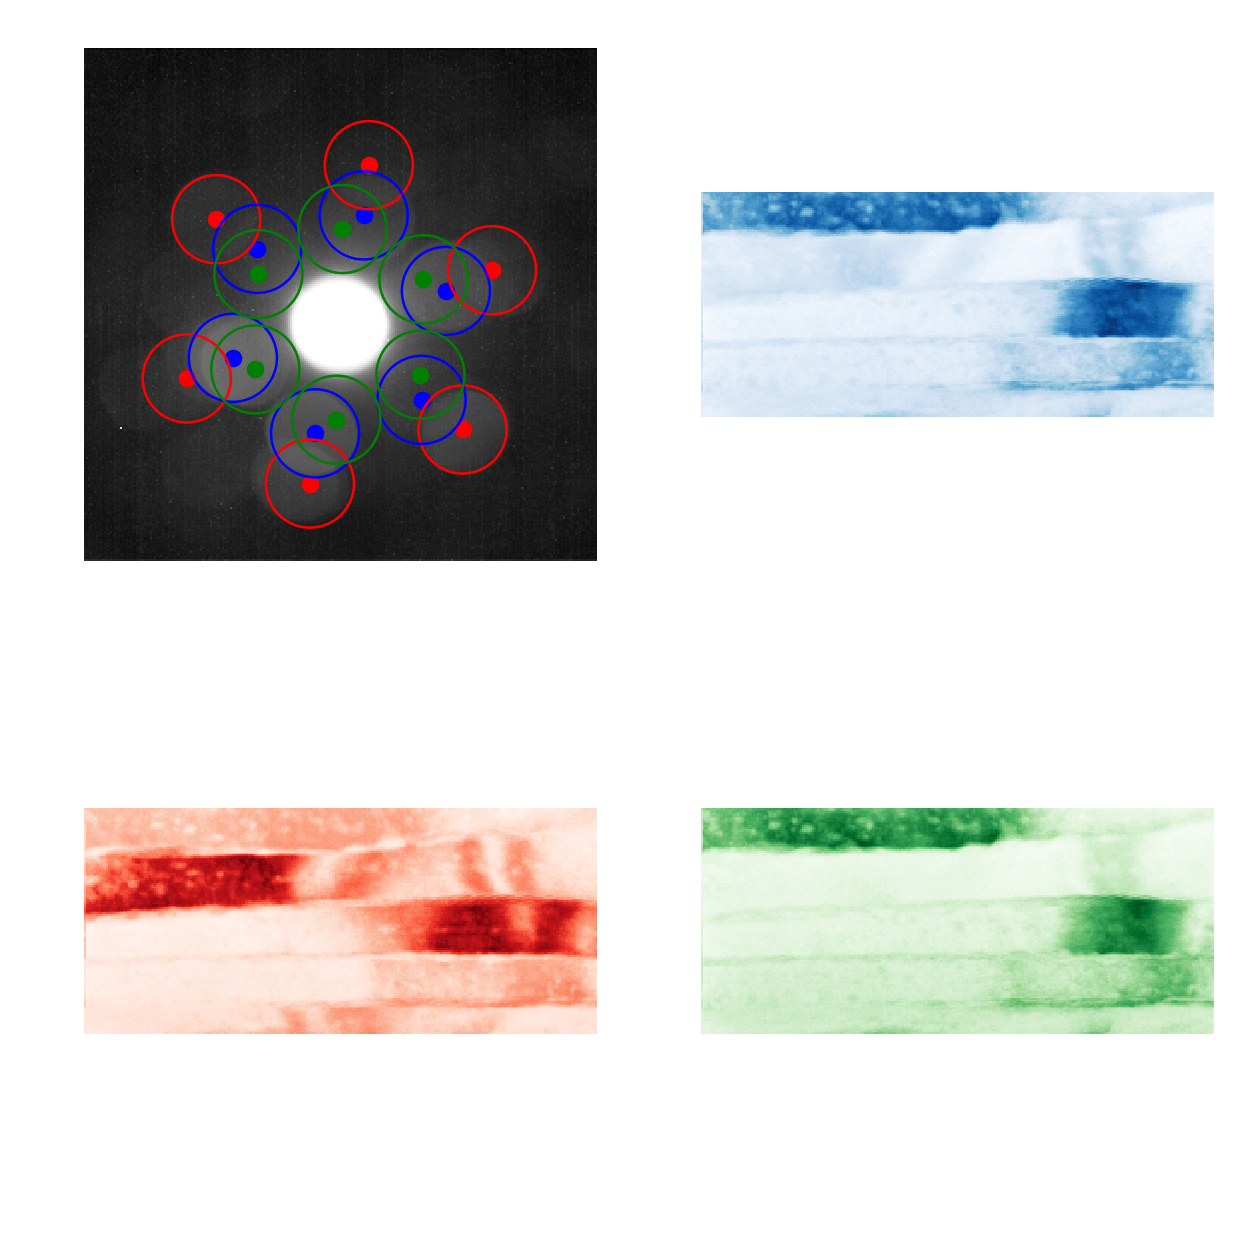

In [20]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(7,7))
fig.tight_layout()
axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
#axs[0,0].matshow(masks[0])

axs[0,0].scatter(six_mask_x[0], six_mask_y[0], color='r')
for i in range(6):
    circ1 = Circle((six_mask_x[0,i],six_mask_y[0,i]),rad,fill=False,color='red')
    axs[0,0].add_patch(circ1)

axs[0,0].scatter(six_mask_x[1], six_mask_y[1], color='b')
for i in range(6):
    circ1 = Circle((six_mask_x[1,i],six_mask_y[1,i]),rad,fill=False,color='blue')
    axs[0,0].add_patch(circ1)
    
axs[0,0].scatter(six_mask_x[2], six_mask_y[2], color='g')
for i in range(6):
    circ1 = Circle((six_mask_x[2,i],six_mask_y[2,i]),rad,fill=False,color='green')
    axs[0,0].add_patch(circ1)


axs[1,0].matshow(output[0], cmap = plt.cm.Reds)
axs[0,1].matshow(output[1], cmap = plt.cm.Blues)
axs[1,1].matshow(output[2], cmap = plt.cm.Greens)



axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

In [21]:
new_output=output
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if 1.3*new_output[0][i,j] >= new_output[1][i,j] and 1.3*new_output[0][i,j] >= new_output[2][i,j]:
                new_output[1][i,j]=0
                new_output[2][i,j]=0
            if new_output[1][i,j] > 1.3*new_output[0][i,j] and new_output[1][i,j] > new_output[2][i,j]:
                new_output[0][i,j]=0
                new_output[2][i,j]=0
            if new_output[2][i,j] > new_output[1][i,j] and new_output[2][i,j] > 1.3*new_output[0][i,j]: 
                new_output[1][i,j]=0
                new_output[0][i,j]=0
                

fig,axs = plt.subplots(figsize=(5,5))
axs.matshow(new_output[0], cmap = my_red)
axs.matshow(new_output[1], cmap = my_blue)
axs.matshow(new_output[2], cmap = my_green)
#axs.matshow(new_output[3], cmap = my_purple, vmax=300000)
#axs.matshow(new_output[4], cmap = my_orange, vmax=200000)

axs.axis('off')
plt.show()

fig.savefig('grain.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


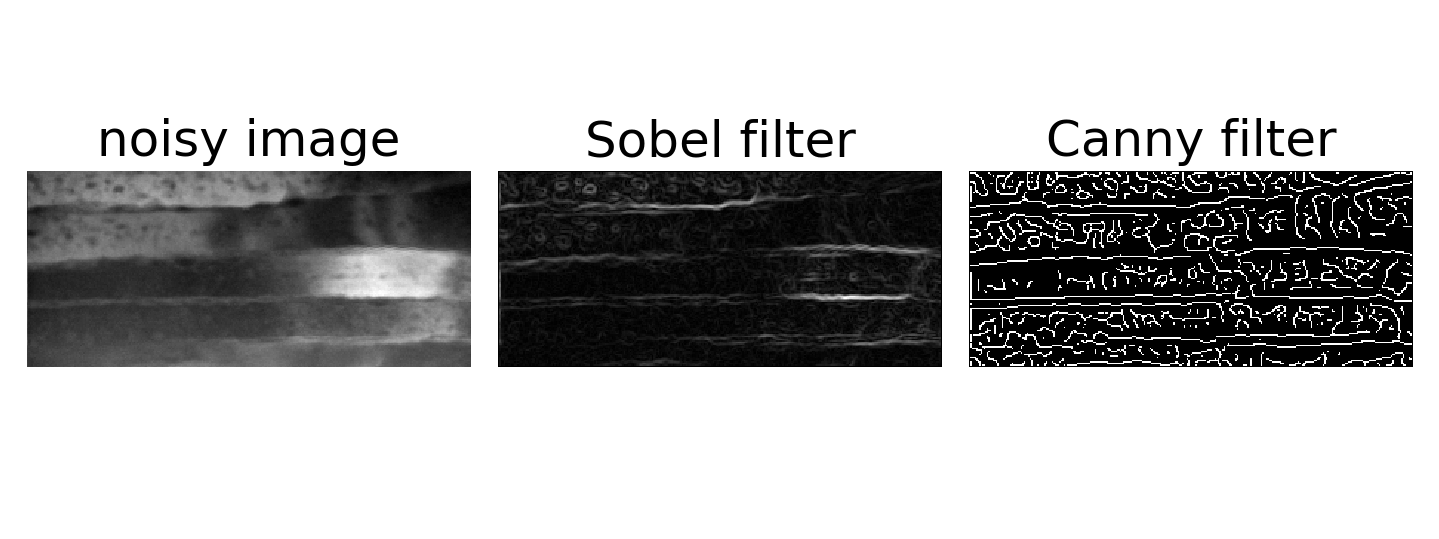

In [22]:
#filter real space image 

from skimage import filters

edges1 = filters.sobel(realimage)
edges2 = canny(realimage, sigma=2)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(realimage, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Sobel filter', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter', fontsize=20)

fig.tight_layout()

plt.show()

[65.5 73.8 85. ]
[ 85.  154.2 160. ]


<IPython.core.display.Javascript object>


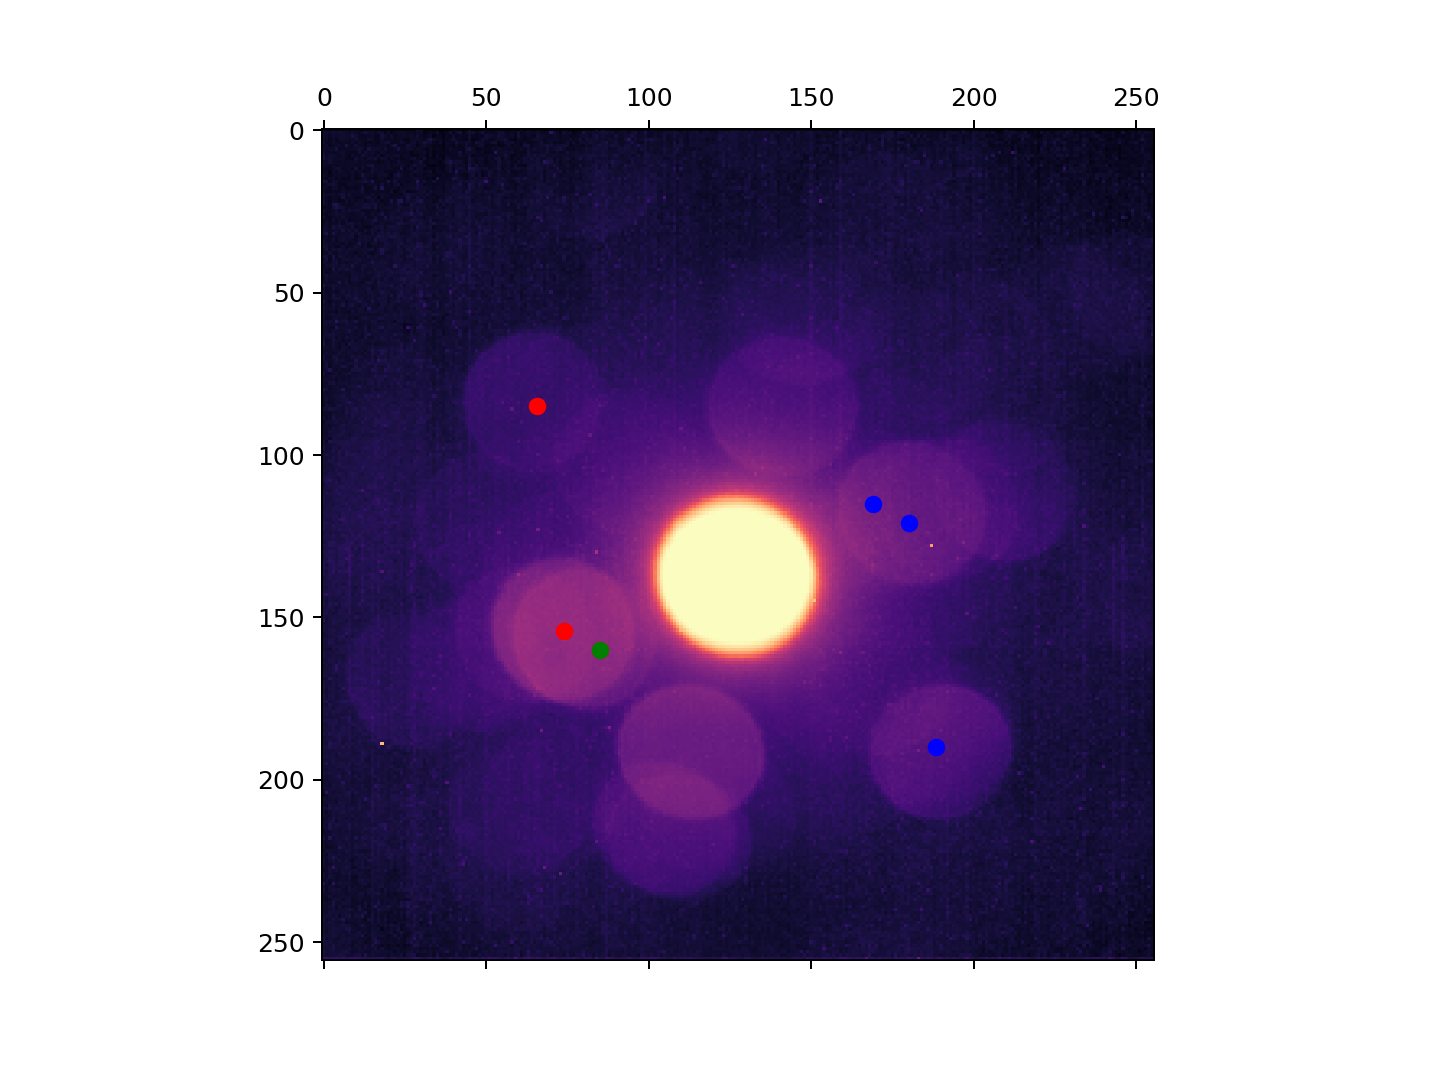

In [23]:
print(cx)
print(cy)

cx_2=-cx+jc*2
cy_2=-cy+ic*2


fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(cx_2,cy_2, color='b')
ax.scatter(cx,cy, color='r')
ax.scatter(cx[2],cy[2], color='g') #let's use this point as our starting poitn for our 6 fold mask
plt.show()

<IPython.core.display.Javascript object>


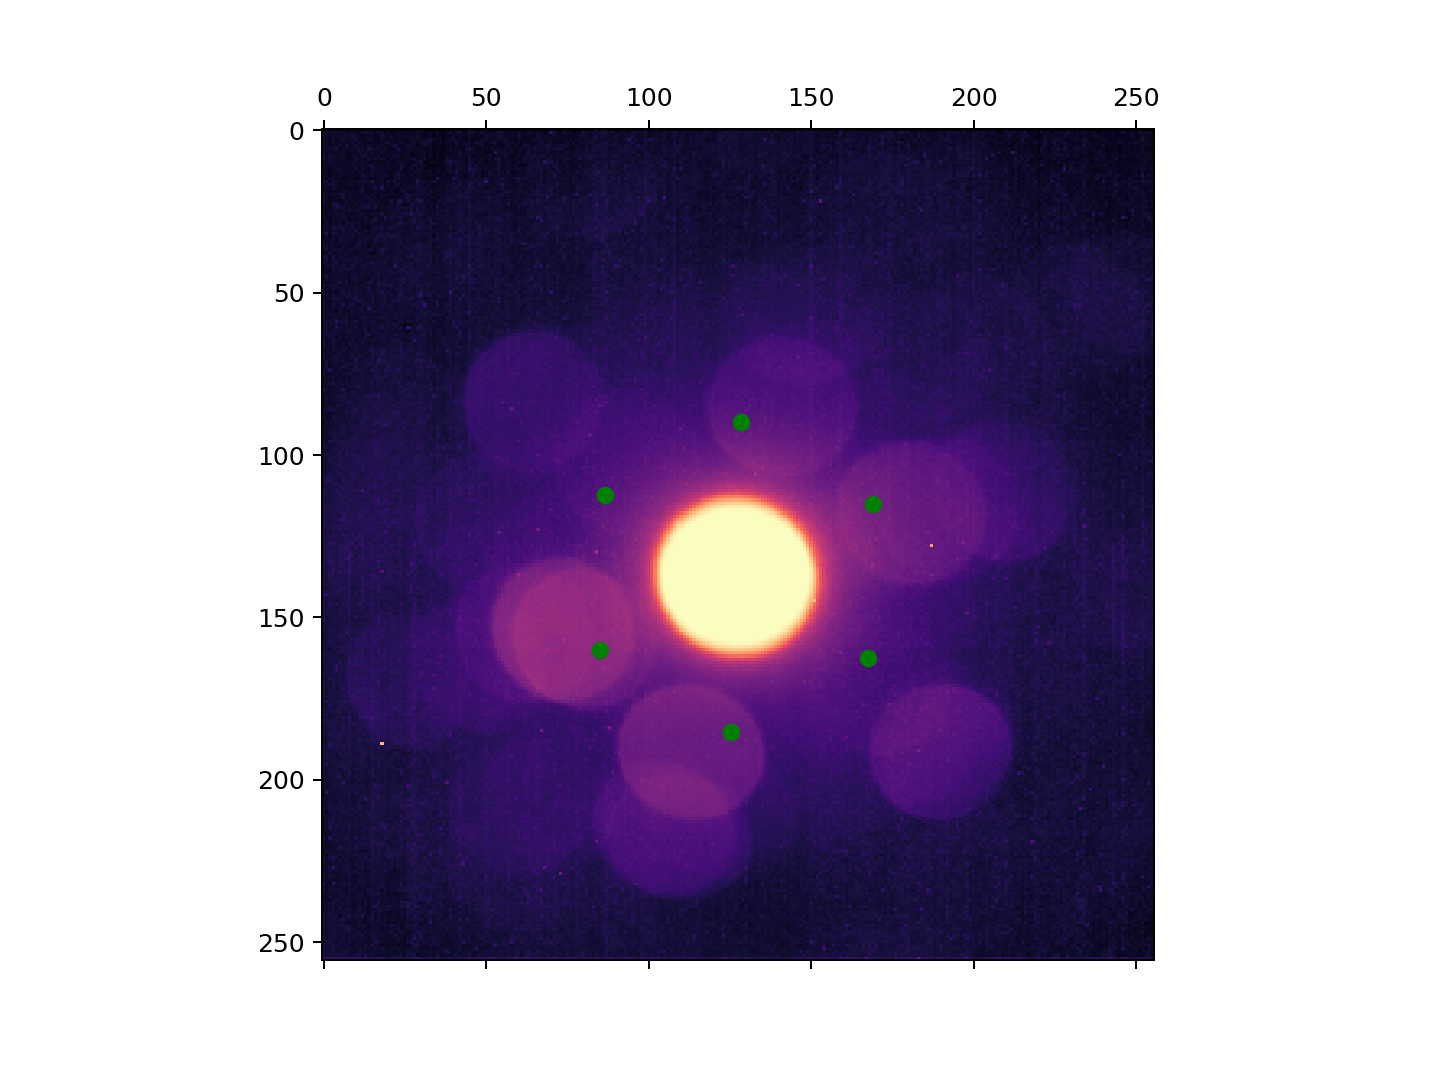

The vector length of this diffraction pattern in pixels is 47.64714052280577


In [24]:
#let's make a 6 fold mask 
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
#print(R)
v=np.array([[cx[2]-jc],[cy[2]-ic]])
#print(v)

six_mask_x=np.zeros((1,6))
six_mask_y=np.zeros((1,6))

six_mask_x[0,0]=cx[2]
six_mask_y[0,0]=cy[2]

v_new=np.zeros((2,1))
for i in range(1,6):
    v=np.dot(v.T,R).T
    six_mask_x[0,i]=v[0,0]+jc
    six_mask_y[0,i]=v[1,0]+ic

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(six_mask_x, six_mask_y, color='g')
plt.show()

pixel_rad=np.sqrt((cx[2]-jc)**2+(cy[2]-ic)**2)
print('The vector length of this diffraction pattern in pixels is ' + str(pixel_rad))

<IPython.core.display.Javascript object>


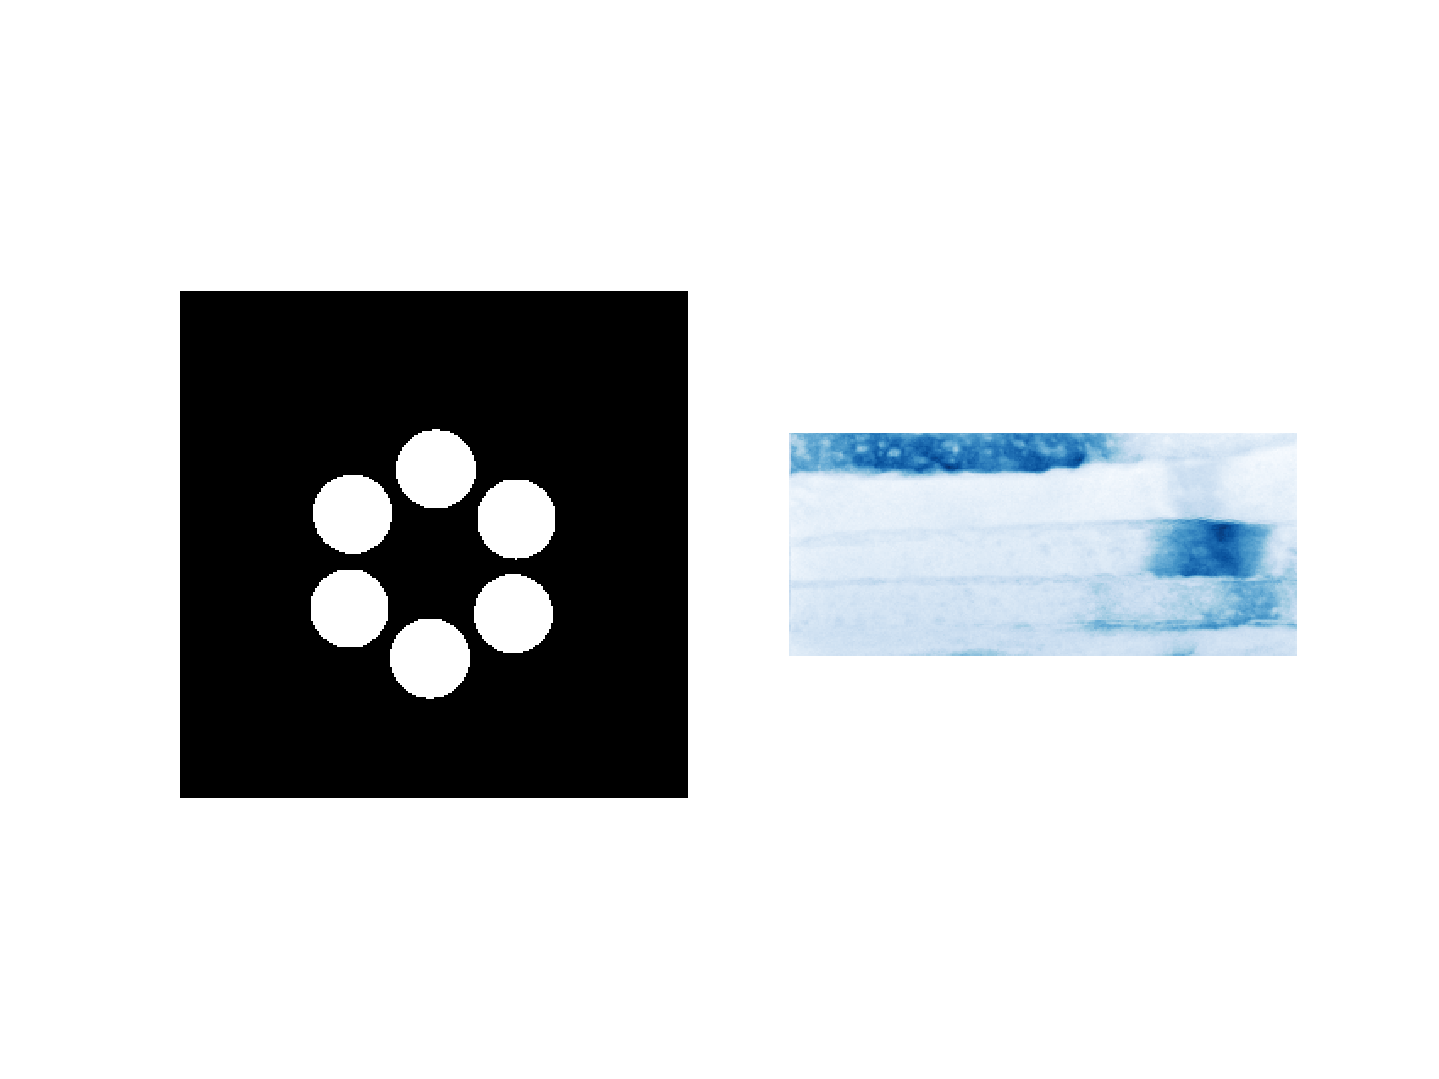

In [25]:
#Integrate first 6 fold mask 

x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (x - six_mask_y[0,0]) ** 2 + (y- six_mask_x[0,0]) ** 2 < 20 ** 2
mask_circle2 = (x - six_mask_y[0,1]) ** 2 + (y- six_mask_x[0,1]) ** 2 < 20 ** 2
mask_circle3 = (x - six_mask_y[0,2]) ** 2 + (y- six_mask_x[0,2]) ** 2 < 20 ** 2
mask_circle4 = (x - six_mask_y[0,3]) ** 2 + (y- six_mask_x[0,3]) ** 2 < 20 ** 2
mask_circle5 = (x - six_mask_y[0,4]) ** 2 + (y- six_mask_x[0,4]) ** 2 < 20 ** 2
mask_circle6 = (x - six_mask_y[0,5]) ** 2 + (y- six_mask_x[0,5]) ** 2 < 20 ** 2
combine_mask = np.logical_or(np.logical_or(np.logical_or(mask_circle1, mask_circle2), \
                    np.logical_or(mask_circle3, mask_circle4)), np.logical_or(mask_circle5, mask_circle6))



DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]-1):
    for j in range(0,aveDP.shape[1]-1): 
        if combine_mask[i,j]: 
            DF_real_space=DF_real_space+datacube.data[:,:,i,j] 

fig,axs = plt.subplots(1,2,figsize=(8,6))
axs[0].imshow(combine_mask)
axs[1].imshow(DF_real_space, cmap=plt.cm.Blues)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

<IPython.core.display.Javascript object>


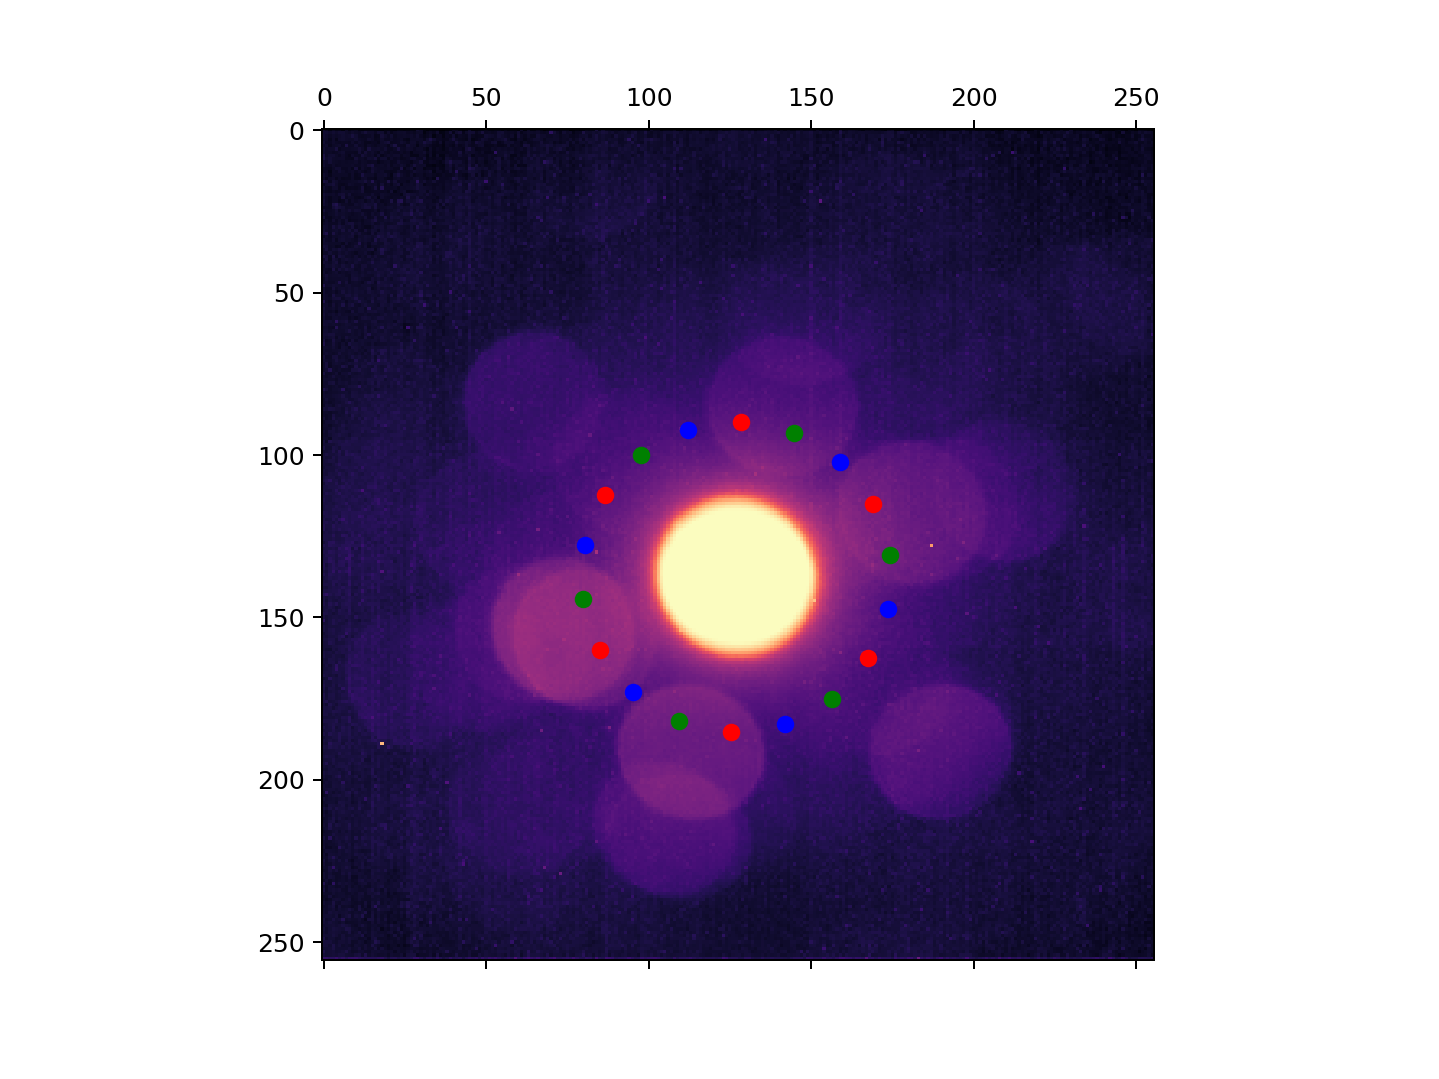

In [26]:
#starting with the initial 6 fold mask, let's rotate it by 20 and 40 degrees to check for rotation 

theta = np.radians(20)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

six_rot_x=np.zeros((2,6))
six_rot_y=np.zeros((2,6))

six_rot_x=np.concatenate((six_mask_x, six_rot_x), axis=0)
six_rot_y=np.concatenate((six_mask_y, six_rot_y), axis=0)


for j in range(6):
    v=np.array([[six_rot_x[0,j]-jc],[six_rot_y[0,j]-ic]])
    for i in range(1,3):
        v=np.dot(v.T,R).T
        six_rot_x[i,j]=v[0,0]+jc
        six_rot_y[i,j]=v[1,0]+ic

fig,ax = plt.subplots(figsize=(8,6))
ax.matshow(np.sqrt(aveDP), cmap = plt.cm.magma)
ax.scatter(six_rot_x[0], six_rot_y[0], color='r')
ax.scatter(six_rot_x[1], six_rot_y[1], color='b')
ax.scatter(six_rot_x[2], six_rot_y[2], color='g')
plt.show()



In [27]:
#Integrate first 6 fold mask 

output=[]
masks=[]
rad=16
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(3):
    mask_circle1 = (x - six_rot_y[k,0]) ** 2 + (y- six_rot_x[k,0]) ** 2 < rad ** 2
    mask_circle2 = (x - six_rot_y[k,1]) ** 2 + (y- six_rot_x[k,1]) ** 2 < rad ** 2
    mask_circle3 = (x - six_rot_y[k,2]) ** 2 + (y- six_rot_x[k,2]) ** 2 < rad ** 2
    mask_circle4 = (x - six_rot_y[k,3]) ** 2 + (y- six_rot_x[k,3]) ** 2 < rad ** 2
    mask_circle5 = (x - six_rot_y[k,4]) ** 2 + (y- six_rot_x[k,4]) ** 2 < rad ** 2
    mask_circle6 = (x - six_rot_y[k,5]) ** 2 + (y- six_rot_x[k,5]) ** 2 < rad ** 2
    combine_mask = np.logical_or(np.logical_or(np.logical_or(mask_circle1, mask_circle2), \
                    np.logical_or(mask_circle3, mask_circle4)), np.logical_or(mask_circle5, mask_circle6))

    masks.append(combine_mask)
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

<IPython.core.display.Javascript object>


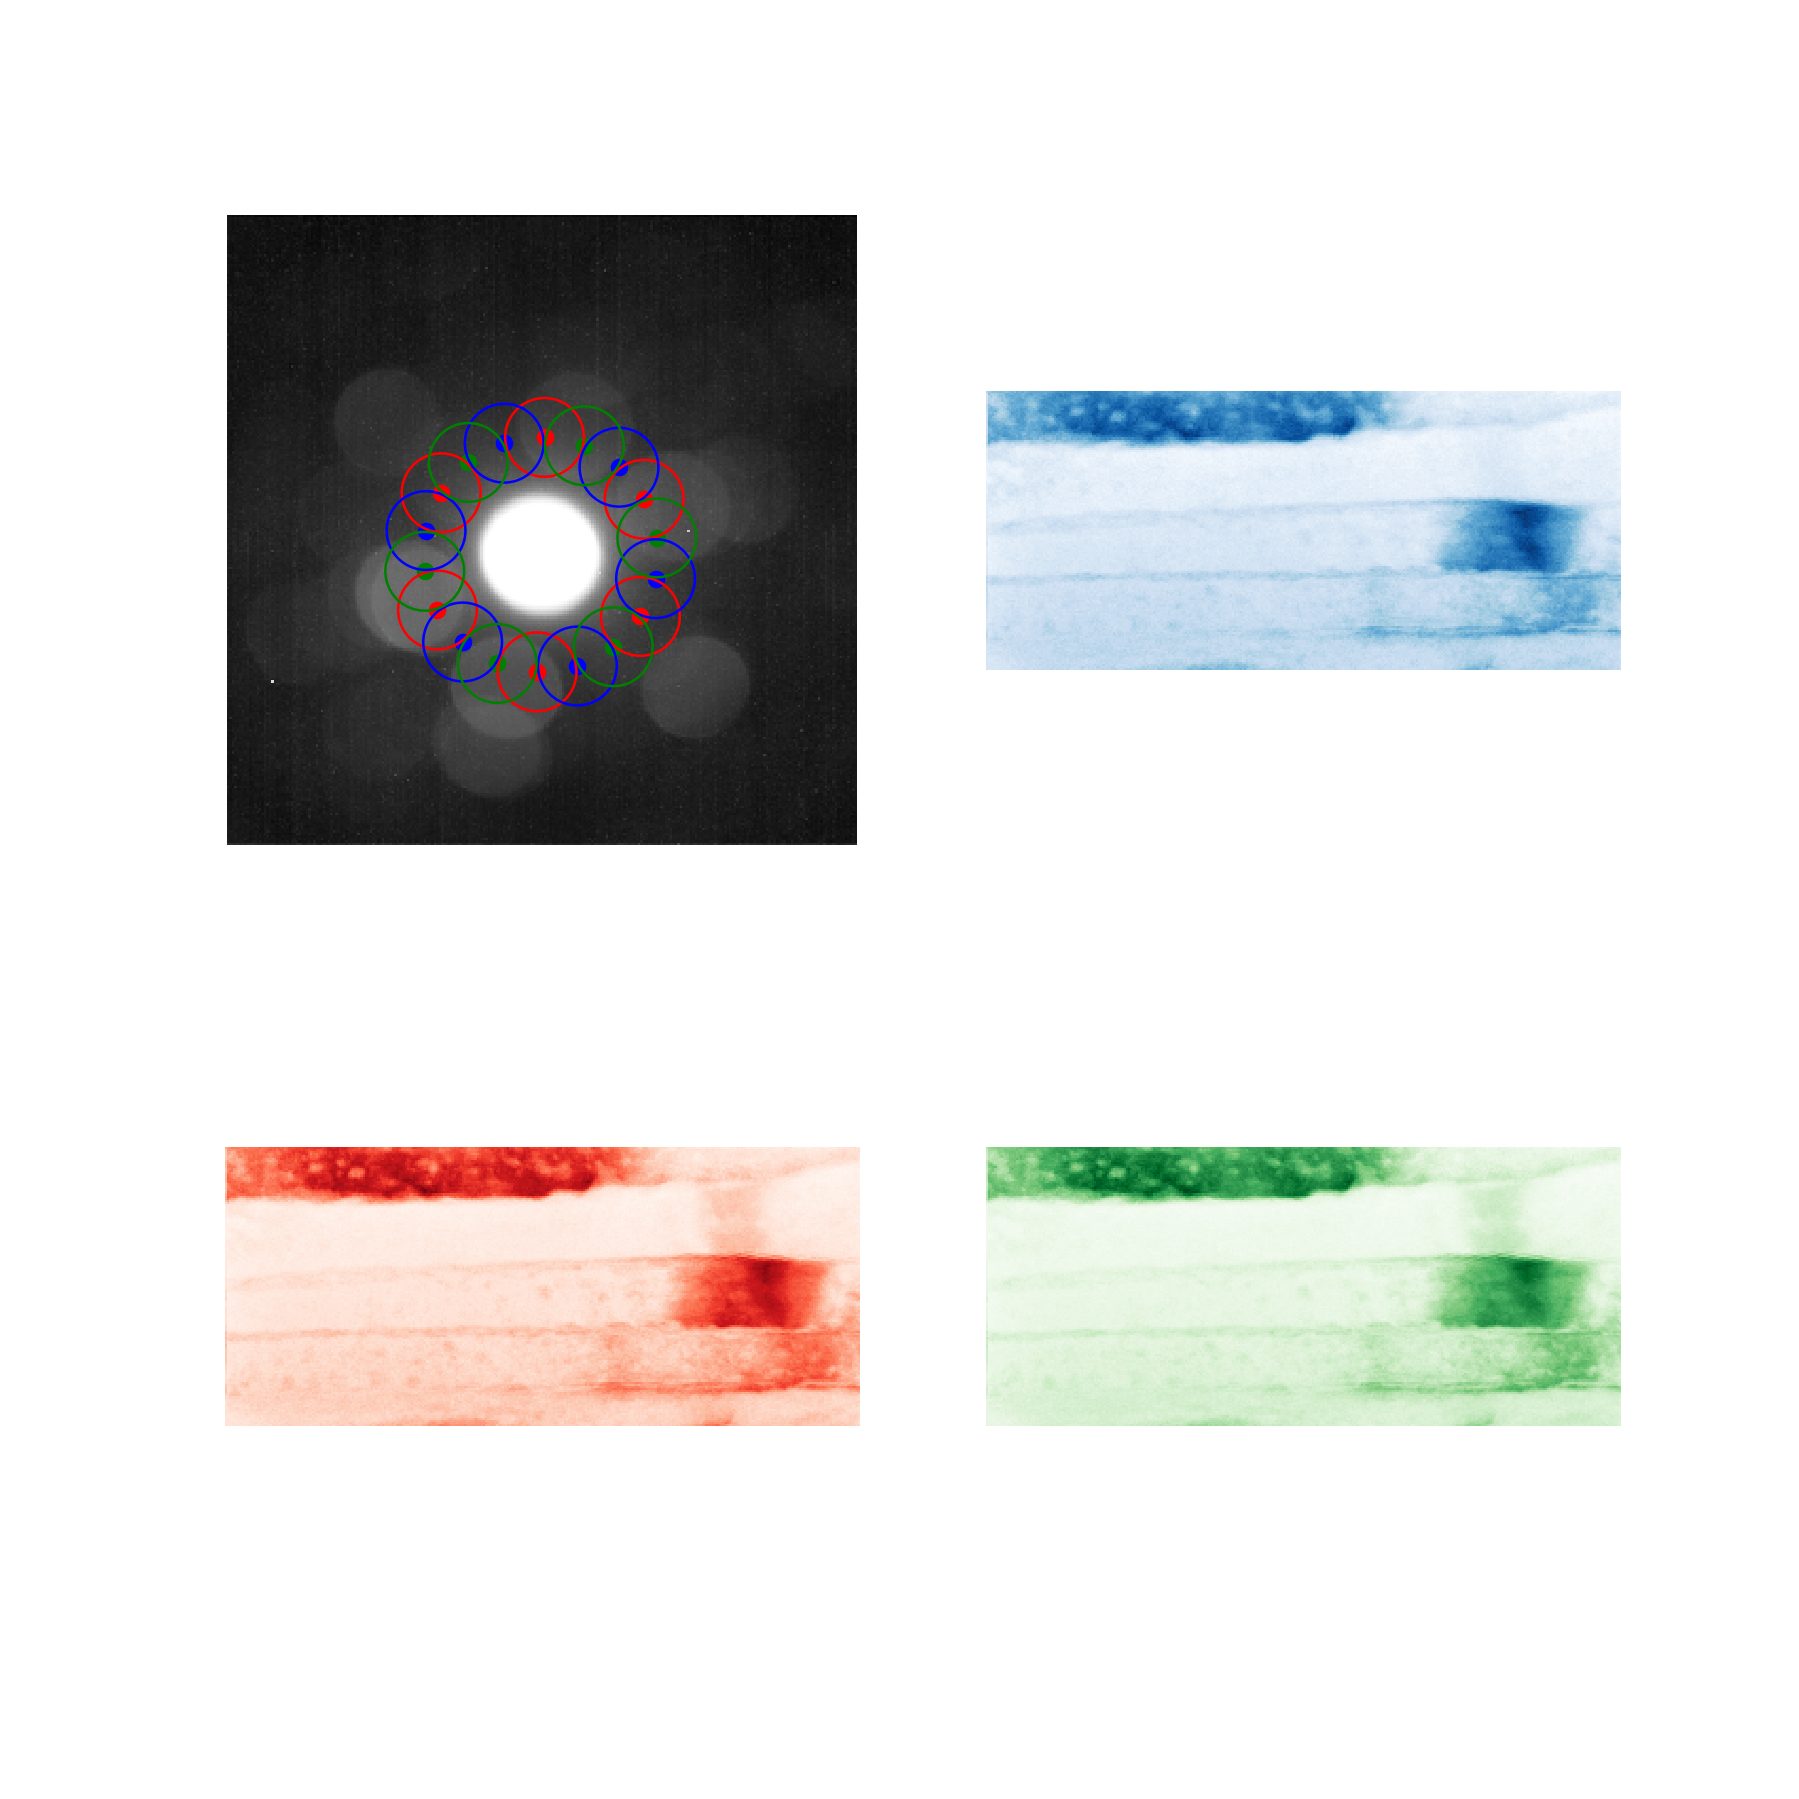

In [28]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

axs[0,0].scatter(six_rot_x[0], six_rot_y[0], color='r')
for i in range(6):
    circ1 = Circle((six_rot_x[0,i],six_rot_y[0,i]),rad,fill=False,color='red')
    axs[0,0].add_patch(circ1)

axs[0,0].scatter(six_rot_x[1], six_rot_y[1], color='b')
for i in range(6):
    circ1 = Circle((six_rot_x[1,i],six_rot_y[1,i]),rad,fill=False,color='blue')
    axs[0,0].add_patch(circ1)
    
axs[0,0].scatter(six_rot_x[2], six_rot_y[2], color='g')
for i in range(6):
    circ1 = Circle((six_rot_x[2,i],six_rot_y[2,i]),rad,fill=False,color='green')
    axs[0,0].add_patch(circ1)


axs[1,0].matshow(output[0], cmap = plt.cm.Reds)
axs[0,1].matshow(output[1], cmap = plt.cm.Blues)
axs[1,1].matshow(output[2], cmap = plt.cm.Greens)



axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

<IPython.core.display.Javascript object>


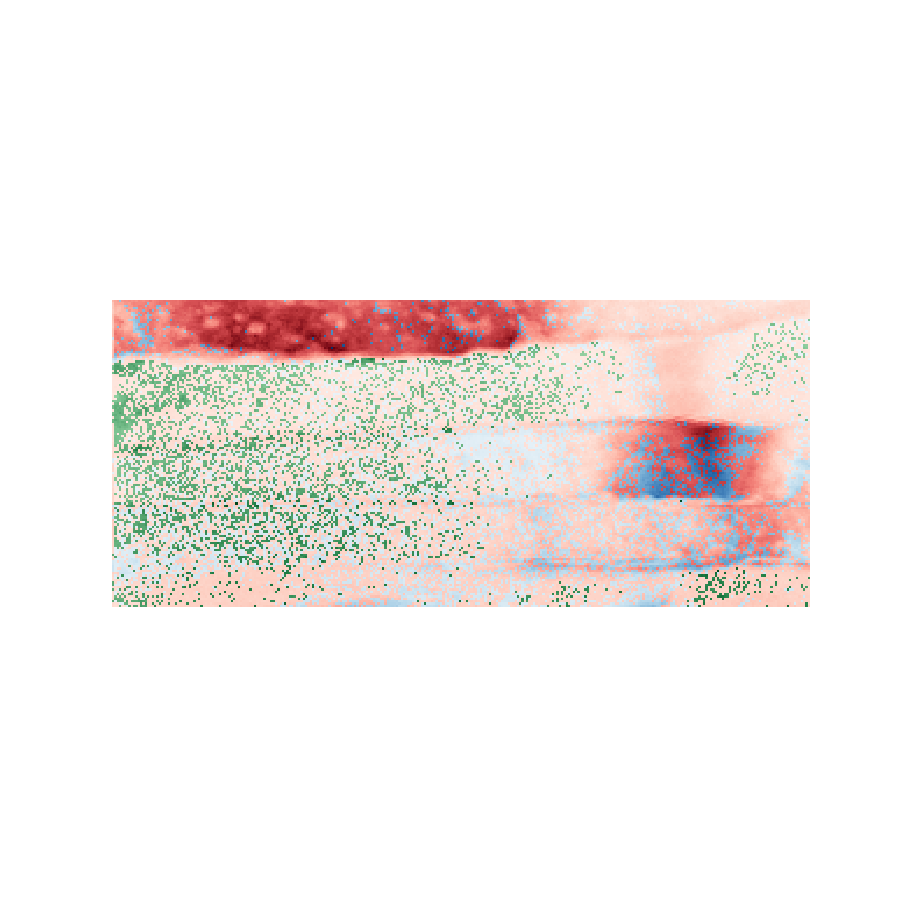

In [29]:
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            if output[0][i,j] >= output[1][i,j] and output[0][i,j] >= output[2][i,j]:
                output[1][i,j]=0
                output[2][i,j]=0
            if output[1][i,j] > output[0][i,j] and output[1][i,j] > output[2][i,j]:
                output[0][i,j]=0
                output[2][i,j]=0
            if output[2][i,j] > output[1][i,j] and output[2][i,j] > output[0][i,j]:
                output[0][i,j]=0
                output[1][i,j]=0

fig,axs = plt.subplots(figsize=(5,5))
axs.matshow(output[0], cmap = my_blue)
axs.matshow(output[1], cmap = my_green)
axs.matshow(output[2], cmap = my_red)

axs.axis('off')

plt.show()

<IPython.core.display.Javascript object>


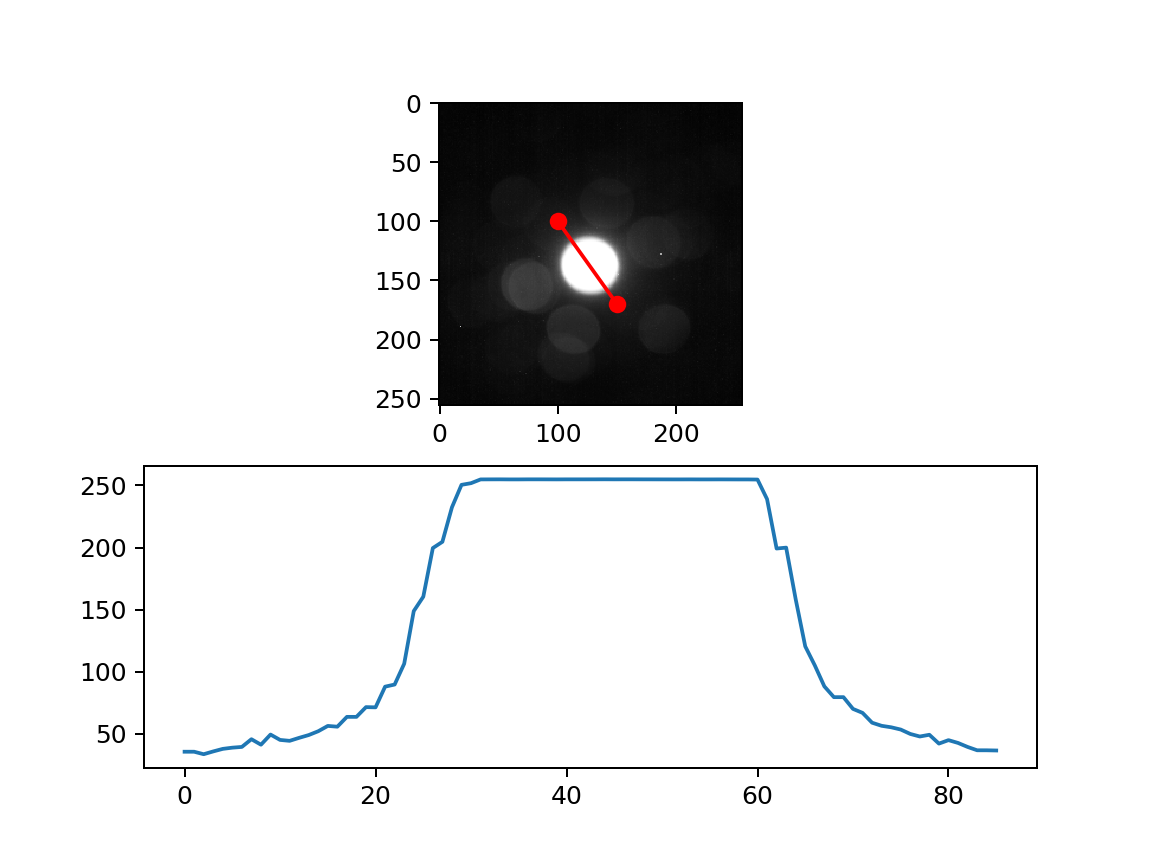

In [30]:
# Make a line with "num" points...
x0, y0 = 100, 100 # These are in _pixel_ coordinates!!
x1, y1 = 150, 170
length = int(np.hypot(x1-x0, y1-y0))
x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

# Extract the values along the line
zi = aveDP[x.astype(np.int), y.astype(np.int)]

#-- Plot...
fig, axes = plt.subplots(nrows=2)
axes[0].imshow(aveDP)
axes[0].plot([x0, x1], [y0, y1], 'ro-')
axes[0].axis('image')

axes[1].plot(zi)

plt.show()

<IPython.core.display.Javascript object>


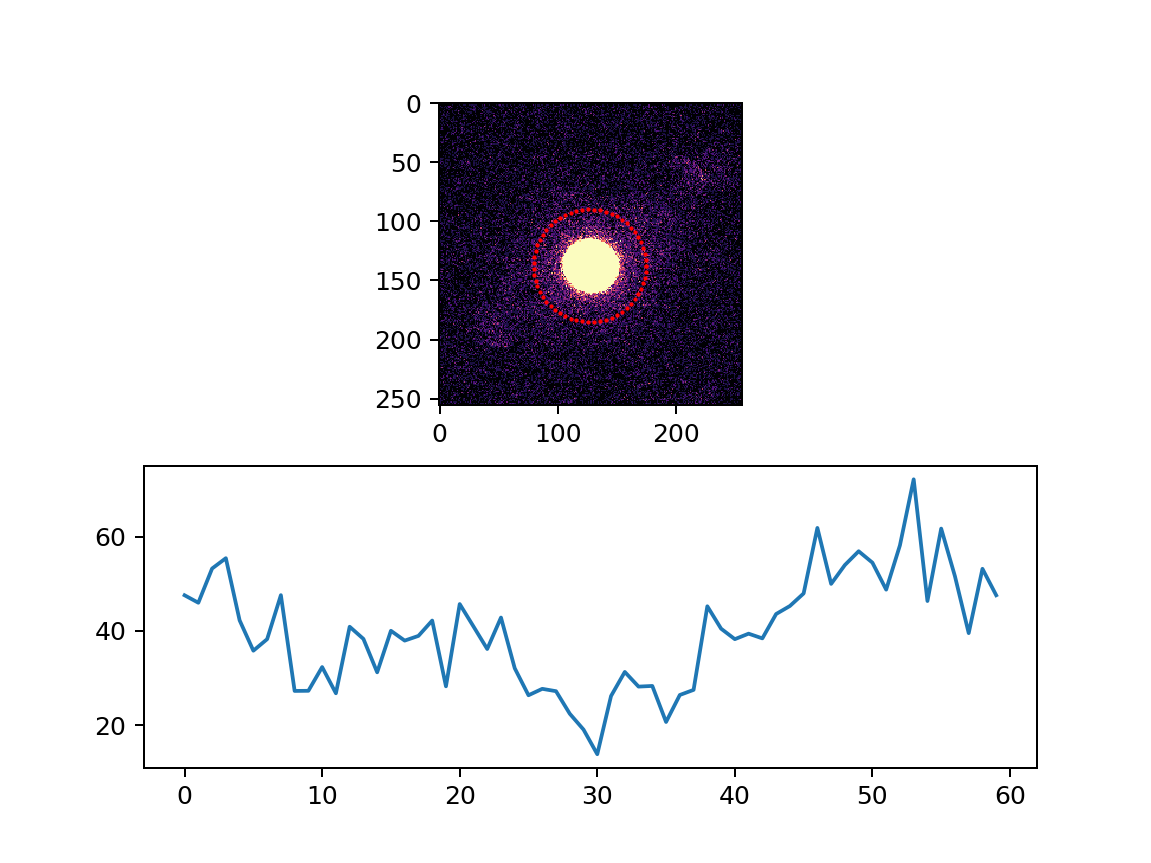

In [31]:
#image=np.average(datacube.data[50:51,50:51,:,:], axis=(0,1))

image=datacube.data[100,100,:,:]

n_dots = 60   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
xs, ys = [], []    # for coordinates of points to plot
ra = pixel_rad          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

xs=np.asarray(xs)
ys=np.asarray(ys)

zi=np.zeros((1,len(xs)))
for ii in range(0,len(xs)):
    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-3:xs[ii].astype(np.int)+3, \
                               ys[ii].astype(np.int)-3:ys[ii].astype(np.int)+3])
    

fig, axes = plt.subplots(nrows=2)

axes[0].scatter(xs, ys, c = 'red', s=0.5)  # plot points 
axes[0].imshow(image, cmap= plt.cm.magma)

axes[1].plot(zi[0,:])

plt.show()


In [32]:
peak_max=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

n_dots = 60   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
ra = pixel_rad 

for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            #image=np.average(datacube.data[i-3:i+3,j-3:j+3,:,:], axis=(0,1))
            image=datacube.data[i,j,:,:]
            xs, ys = [], []    
      

            for ang in angs:
                x = cx + ra*np.cos(ang)
                y = cy + ra*np.sin(ang)
                xs.append(x)   
                ys.append(y)   

            xs=np.asarray(xs)
            ys=np.asarray(ys)

            zi=np.zeros((1,len(xs)))
            for ii in range(0,len(xs)):
                    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-5:xs[ii].astype(np.int)+5, \
                               ys[ii].astype(np.int)-5:ys[ii].astype(np.int)+5])
            
            peak_max[i,j]=np.argmax(zi)
                


<IPython.core.display.Javascript object>


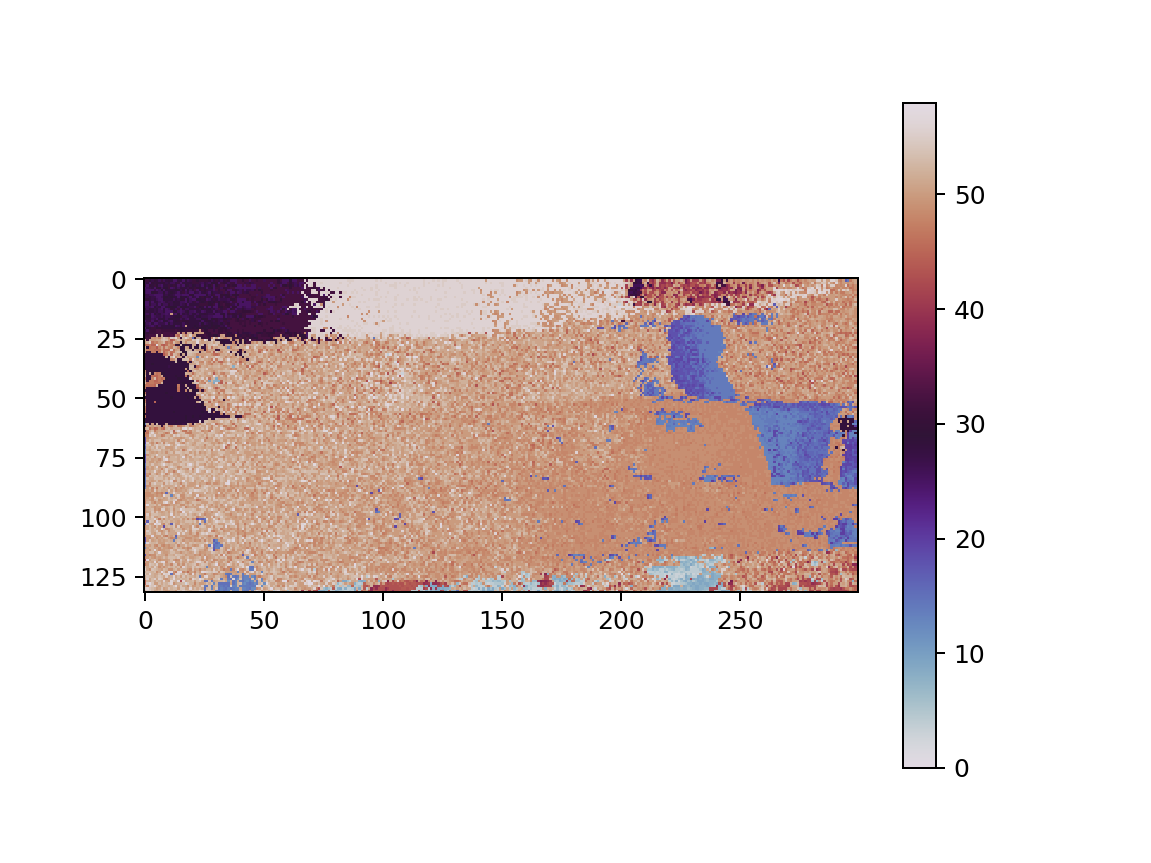

In [33]:
fig, axes = plt.subplots()

#map=axes.imshow(peak_max%10, cmap=plt.cm.twilight)  
map=axes.imshow(peak_max, cmap=plt.cm.twilight)  
fig.colorbar(map)
plt.show()